# 목표
국가 및 출연배우 탐색

In [88]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
# print(matplotlib.__file__)
import subprocess

mpl_file = matplotlib.__file__
mpl_file_loc = '/'.join(mpl_file.split('/')[:-1]) + '/mpl-data/fonts/ttf/'

# 폰트 복사

subprocess.run(f'cp /usr/share/fonts/truetype/nanum/Nanum* {mpl_file_loc}', shell=True)
print(mpl_file_loc)
subprocess.run('rm -rf ~/.cache/matplotlib/*', shell=True)
plt.rcParams["font.family"] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지
# 커널 재시작

/home/innovation/codessey/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/


In [89]:
class MovieDataLoader:
    def __init__(self, file_path = '../data'):
        self.file_path = file_path
        self.__load_data()

    def __load_data(self):
        for file_name in os.listdir(self.file_path):
            self.file_name = []
            if file_name.endswith('.csv'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name)))
            if file_name.endswith('.txt'):
                setattr(self, os.path.splitext(file_name)[0], pd.read_csv(os.path.join(self.file_path, file_name), sep='\t', engine='python'))



In [90]:
movie_data_loader = MovieDataLoader()
casting = movie_data_loader.castings
countries = movie_data_loader.countries
genres = movie_data_loader.genres
movies = movie_data_loader.movies
peoples = movie_data_loader.peoples
rates = movie_data_loader.rates

<Axes: title={'center': 'Countries bar plot'}, xlabel='country', ylabel='count'>

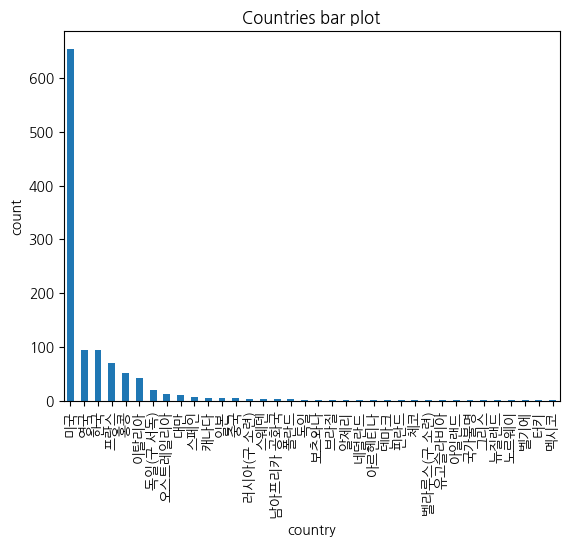

In [91]:
## country bar plot
countries.head()
plt.title('Countries bar plot')
plt.xlabel('countries')
plt.ylabel('count')
countries['country'].value_counts().plot(kind='bar')

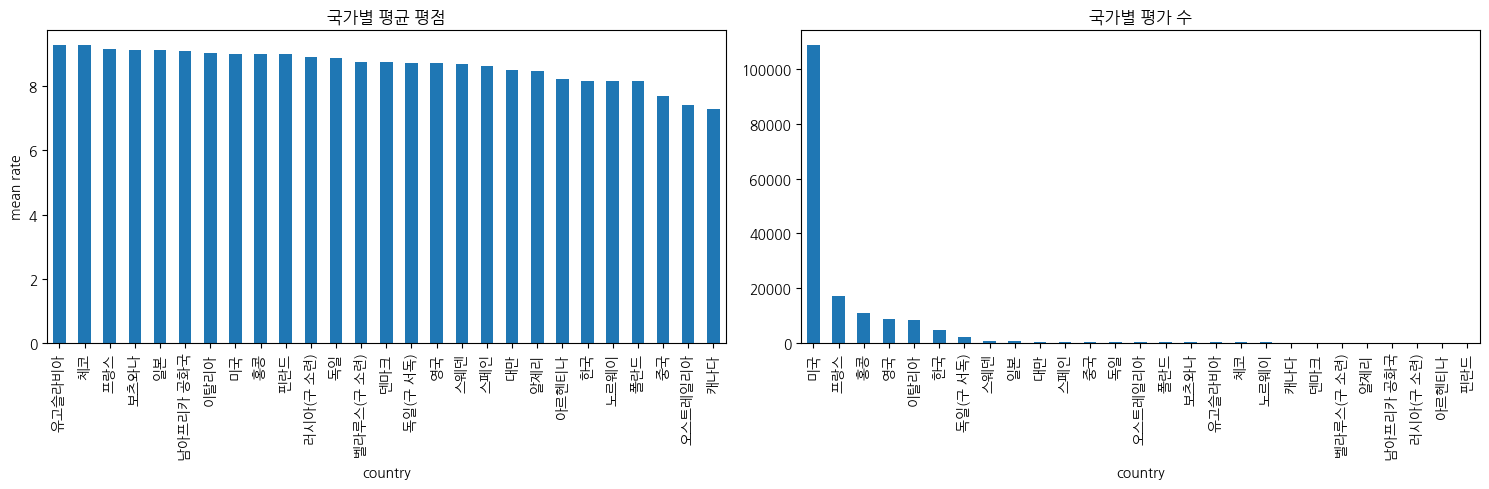

In [92]:
# 국가별 평점 분포

df = pd.merge(rates, movies, on='movie').merge(countries, on='movie')
df_grouped_by_country = df.groupby('country')['rate'].agg(['mean', 'count'])
df_grouped_by_country.sort_values(by='mean', ascending=False)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('국가별 평균 평점')
df_grouped_by_country['mean'].sort_values(ascending=False).plot(kind='bar')
plt.xlabel('country')
plt.ylabel('mean rate')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.title('국가별 평가 수')
df_grouped_by_country['count'].sort_values(ascending=False).plot(kind='bar')
plt.xlabel('country')
plt.tight_layout()

top_5_countries_index = df_grouped_by_country['count'].sort_values(ascending=False).index[:5]


In [ ]:
# 국가별 장르 분포

# 국가별 장르 비율 시각화
df_genre = pd.merge(movies, countries, on='movie').merge(genres, on='movie')
# # 국가별 장르 카운트
genre_by_country = df_genre.groupby(['country', 'genre']).size().unstack(fill_value=0)

# # 비율로 변환
genre_ratio = genre_by_country.div(genre_by_country.sum(axis=1), axis=0)
# # 시각화
plt.figure(figsize=(15, 8))
genre_ratio.plot(kind='bar', stacked=True)
plt.title('국가별 장르 비율')
plt.xlabel('국가')
plt.ylabel('비율')
plt.legend(title='장르', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# # 상위 5개국의 장르 비율만 보기

genre_ratio_top5 = genre_ratio.loc[top_5_countries_index]

plt.figure(figsize=(12, 6))
genre_ratio_top5.plot(kind='bar', stacked=True)
plt.title('상위 5개국의 장르 비율')
plt.xlabel('국가')
plt.ylabel('비율')
plt.legend(title='장르', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [86]:
# 출연 배우 탐색

## 가장 많은 영화에 주연으로 출연한 배우 찾기
casting.head()
# movies.head()
df = pd.merge(casting, movies, on='movie', how='left').merge(peoples, on='people', how='left')
df.head()
leading_actors = df.query('leading == 1').groupby(['people'])['movie'].count().reset_index(name='count').sort_values(by='count', ascending=False).merge(peoples[['people', 'korean', 'original']], on='people', how='inner')
leading_actors.head()   


,people,count,korean,original
0,1327,16,로버트 드 니로,Robert De Niro
1,1843,13,안성기,NaN
2,1422,11,숀 코네리,Sean Connery
3,1507,11,실베스터 스탤론,Sylvester Stallone
4,290,11,클린트 이스트우드,Clint Eastwood


In [ ]:
supporting_actors = df.query('leading == 0').groupby(['people'])['movie'].count().reset_index(name='count').sort_values(by='count', ascending=False).merge(peoples[['people', 'korean', 'original']], on='people', how='inner')
supporting_actors.head()


,people,count,korean,original
0,2248,9,우마,Wu Ma
1,40425,7,나갑성,NaN
2,7612,7,박예숙,NaN
3,7619,6,박용팔,NaN
4,11042,6,워터 코에닉,Walter Koenig


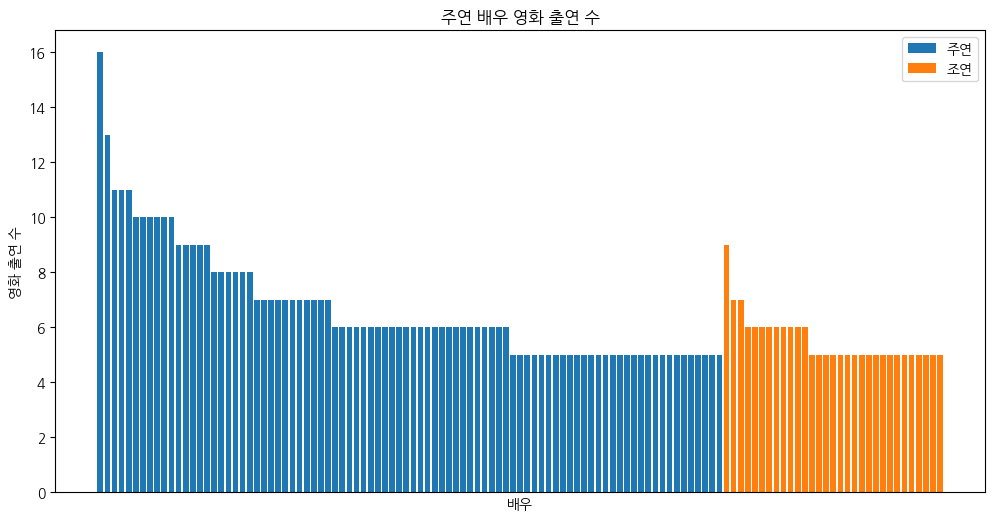

In [ ]:
leading_actors_over_5_movies = leading_actors[leading_actors['count'] >= 5]
supporting_actors_over_5_movies = supporting_actors[supporting_actors['count'] >= 5]

plt.figure(figsize=(12, 6))
plt.title('주연 배우 영화 출연 수')
plt.xlabel('배우')
plt.ylabel('영화 출연 수')
plt.bar(leading_actors_over_5_movies['korean'], leading_actors_over_5_movies['count'], label='주연')
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.bar(supporting_actors_over_5_movies['korean'], supporting_actors_over_5_movies['count'], label='조연')
plt.legend()
plt.show()



In [ ]:
# 5편 이상 출연한 배우중 평균 평점이 높은 배우 찾기, 평점은 10개 이상인 영화만 평점 계산

rate_movie = movies.merge(rates, on='movie')
movies_over_10_rate = rate_movie.groupby('movie').agg({'rate': 'mean', 'movie': 'count'}).rename(columns={'movie': 'rate_count'})
movies_over_10_rate = movies_over_10_rate.reset_index().query('rate_count >= 10')
movies_over_10_rate = movies_over_10_rate.merge(casting, on='movie', how='inner')
movies_over_10_rate.head()

leading_actor_over_5_movies_over_10_rate = leading_actors_over_5_movies.merge(movies_over_10_rate, on='people', how='inner').drop_duplicates(subset=['people'])
leading_actor_over_5_movies_over_10_rate.sort_values(by='rate', ascending=False).head(5)




,people,count,korean,original,movie,rate,rate_count,order,leading
341,889,5,커스티 앨리,Kirstie Alley,10176,9.722222,18,4,1
177,496,7,제라르 드빠르디유,Gerard Depardieu,10472,9.469388,98,2,1
129,1822,8,성룡,Jackie Chan,10115,9.370229,262,1,1
219,226,6,찰리 채플린,Charles Chaplin,10249,9.341379,1160,1,1
33,1507,11,실베스터 스탤론,Sylvester Stallone,10021,9.317726,1196,1,1
